# Exploratory data analysis (EDA) and Machine Learning on the SGIJ Vertica Dataset

Make a EDA Study for all players activate during a year selected

In [4]:
import math
from datetime import date
from datetime import datetime
from collections import Counter, OrderedDict
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
from pandas.plotting import register_matplotlib_converters
import matplotlib
import matplotlib.pyplot as plt
import mysql.connector
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.stats import linregress
from scipy import stats
from scipy.spatial.distance import cdist
from IPython.display import display, Markdown
%matplotlib inline

register_matplotlib_converters()

Connect to Vertica databasef from credentials

NoteNook Year EDA Study

In [5]:
YEAR = 2015

Vertica Database connection string

In [7]:
config = {'host': '192.168.1.125',
             'port': 5433,
             'user': 'dbadmin',
             'password': 'password',
             'database': 'VMart',
             # default throw error on invalid UTF-8 results
             'unicode_error': 'strict',
             # SSL is disabled by default
             'ssl': False,
             # using server-side prepared statements is disabled by default
             'use_prepared_statements': False,
             # connection timeout is not enabled by default
             'connection_timeout': 5}

try:
  cnx = vertica_python.connect(**config)
except vertica.connector.Error as err:
  if err.errno == errorcode.ER_ACCESS_DENIED_ERROR:
    print("Something is wrong with your user name or password")
  elif err.errno == errorcode.ER_BAD_DB_ERROR:
    print("Database does not exist")
  else:
    print(err)

## Sex player distribution

Get raw Dataset

In [7]:
cursor = cnx.cursor()

query = ('SELECT pl.sex, COUNT(pl.sex) as total'
        ' FROM gaming.player pl'
        ' WHERE YEAR(pl.activation_date) = %s'
        ' GROUP BY pl.sex' 
        ' ORDER BY pl.sex') %YEAR

cursor.execute(query)

# return a list of tuples
result_sex = list(cursor.fetchall())

Plot sex distribution Dataset

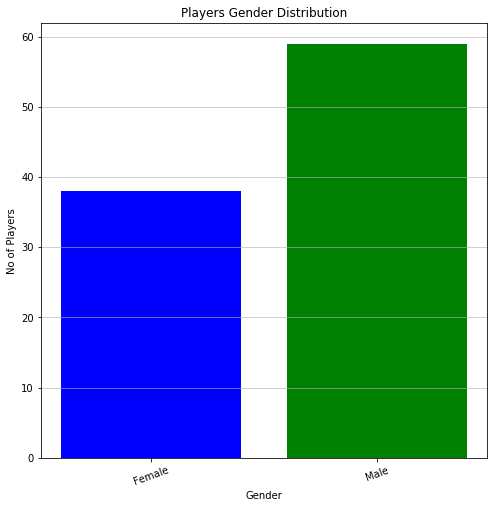

Female Dataset Size: 38
Male Dataset Size: 59
------------------------
Dataset Size: 97


In [8]:
data = np.array(result_sex) # numpy convert to string all values
labels = data[:, 0]
values = data[:, 1].astype(int)
    
plt.figure(figsize=(8, 8))  
plt.bar(labels, values, color=('blue', 'green'))
plt.title('Players Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('No of Players')
plt.xticks(np.arange(labels.size), ('Female', 'Male'), rotation=20)
plt.grid(axis='y', alpha=0.75)
plt.show()

print('Female Dataset Size: ' + str(values[0]))
print('Male Dataset Size: ' + str(values[1]))
print('------------------------')
print('Dataset Size: ' + str(sum(values)))

## Betting Frequency

Get raw dataset for betting frequency, total number of activity days (days on witch a player placed at least one live-action bet))

In [9]:
cursor = cnx.cursor()

query = ("SELECT COUNT(*) AS total"
         " FROM gaming.player pl, gaming.account ac"
         " WHERE pl.operator_id = ac.operator_id"
         "   AND pl.player_id = ac.player_id"
         "   AND YEAR(pl.activation_date) = %s"
         " GROUP BY ac.operator_id, ac.player_id") %YEAR

cursor.execute(query)

# return a list of tuples
result_betting_frequency = list(cursor.fetchall())

Plot betting frequency distribution per player

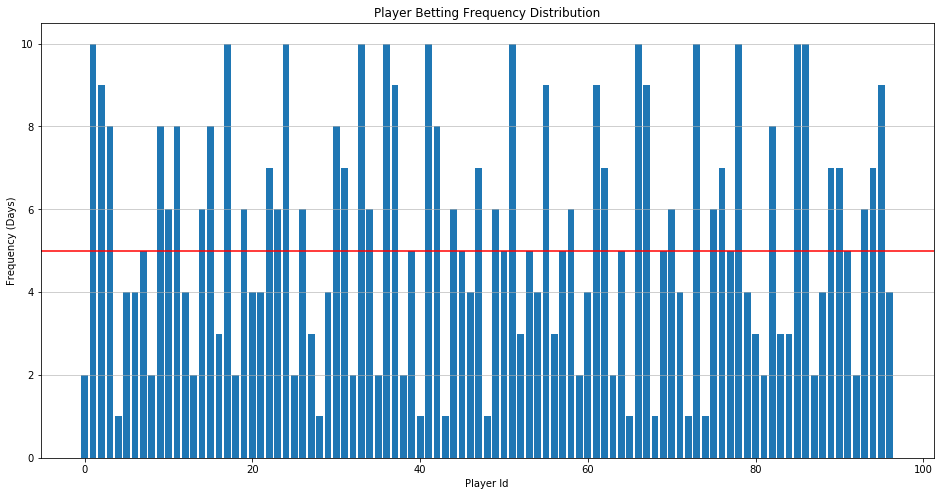

Mean bettings days: 5.0


In [10]:
data = np.array(result_betting_frequency) # numpy convert to string all values
data = data.astype(int)

betting_frequency_values = data[:, 0]

mean = round(betting_frequency_values.mean())

#print(betting_frequency_values.size)

plt.figure(figsize=(16, 8))  
plt.bar(np.arange(betting_frequency_values.size), betting_frequency_values)
plt.title('Player Betting Frequency Distribution')
plt.xlabel('Player Id')
plt.ylabel('Frequency (Days)')
plt.axhline(y=mean, color='r', linestyle='-')
plt.grid(axis='y', alpha=0.75)
plt.show()

print('Mean bettings days: ' + str(mean))

## Betting Intensity

Get raw dataset for betting intensity, total number of live-action bets divided by frequency.

In [11]:
cursor = cnx.cursor()

query = ("SELECT SUM(bettings) / COUNT(*) as total"
         " FROM gaming.player pl, gaming.account ac"
         " WHERE pl.operator_id = ac.operator_id"
         "   AND pl.player_id = ac.player_id"
         "   AND YEAR(pl.activation_date) = %s"                  
         " GROUP BY pl.operator_id, pl.player_id;") %YEAR

cursor.execute(query)

# return a list of tuples
result_betting_intensity = list(cursor.fetchall())

Plot betting intensity distribution per player

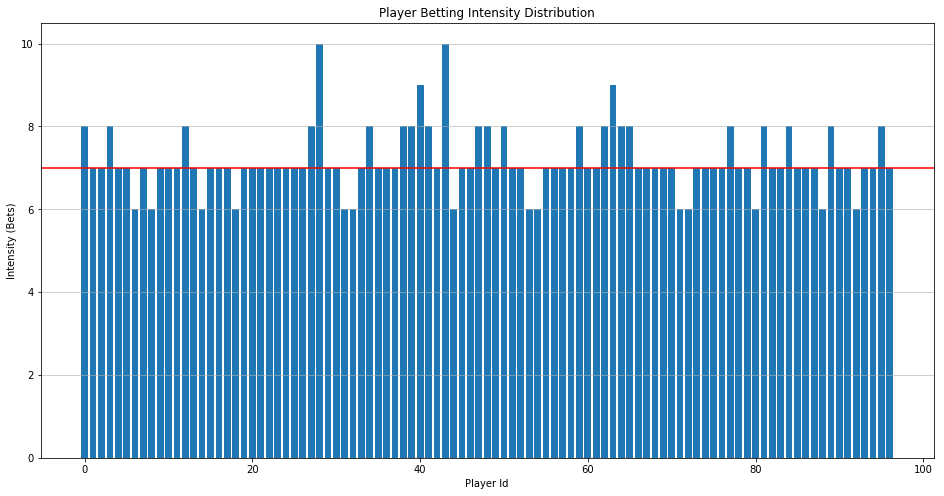

Mean Betting Intensity : 7.0


In [12]:
data = np.array(result_betting_intensity) # numpy convert to string all values
data = data.astype(int)

betting_intensity_values = data[:, 0]

mean = round(betting_intensity_values.mean())

#print(betting_intensity_values.size)

plt.figure(figsize=(16, 8))
plt.bar(np.arange(betting_intensity_values.size), betting_intensity_values)
plt.title('Player Betting Intensity Distribution')
plt.xlabel('Player Id')
plt.ylabel('Intensity (Bets)')
plt.axhline(y=mean, color='r', linestyle='-')
plt.grid(axis='y', alpha=0.75)
plt.show()

print('Mean Betting Intensity : ' + str(mean))

## Betting Intensity Histogram

Get raw dataset for betting Intensity Histogram

In [13]:
cursor = cnx.cursor()

query = ("SELECT SUM(bettings) as total"
         " FROM gaming.player pl, gaming.account ac"
         " WHERE pl.operator_id = ac.operator_id"
         "   AND pl.player_id = ac.player_id"
         "   AND YEAR(pl.activation_date) = %s"                  
         " GROUP BY pl.operator_id, pl.player_id;") %YEAR

cursor.execute(query)

# return a list of tuples
result_betting_histogram = list(cursor.fetchall())

Plot betting betting intesity histogram

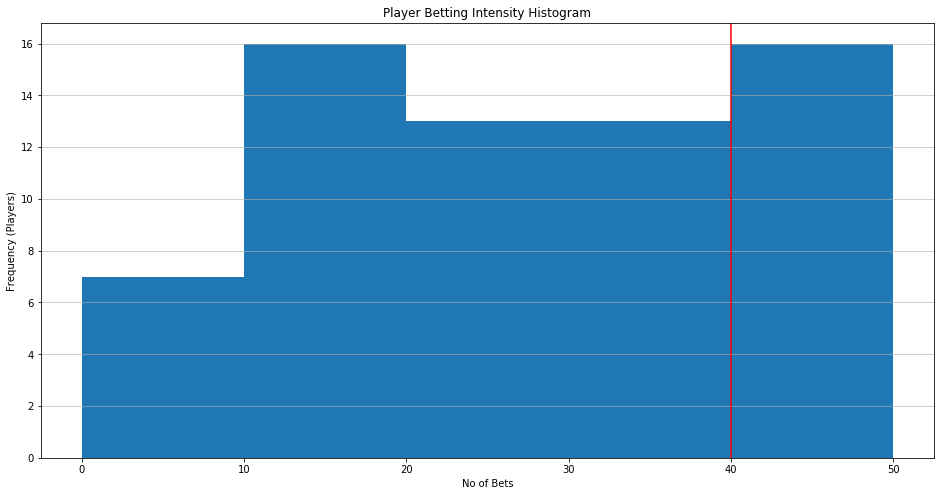

Mean Betting Intensity : 40.0


In [14]:
data = np.array(result_betting_histogram) # numpy convert to string all values
data = data.astype(int)

#labels = data[:, 0]
values = data[:, 0]

mean = round(values.mean())

plt.figure(figsize=(16, 8))
cuenta, cajas, ignorar = plt.hist(values, bins=np.arange(0, 60, 10))
plt.title('Player Betting Intensity Histogram')
plt.xlabel('No of Bets')
plt.ylabel('Frequency (Players)')
plt.axvline(x=mean, color='r', linestyle='-')
plt.grid(axis='y', alpha=0.75)
plt.show()

print('Mean Betting Intensity : ' + str(mean))

## Betting Variability

Get raw Dataset for Betting Variability. Standard Deviation of wagers

In [16]:
cursor = cnx.cursor()

query = ("SELECT ac.operator_id as operator_id, ac.player_id as player_id, SUM(ac.bettings) as total"
         " FROM gaming.player pl, gaming.account ac"
         " WHERE pl.operator_id = ac.operator_id"
         "   AND pl.player_id = ac.player_id"
         "  AND YEAR(pl.activation_date) = %d"
         " GROUP BY ac.operator_id, ac.player_id, DATE(ac.checkin_time)"
         " ORDER BY ac.operator_id, ac.player_id") %YEAR

cursor.execute(query)

# return a list of tuples
result_betting_variability = list(cursor.fetchall())

Plot betting betting variability distribution per player

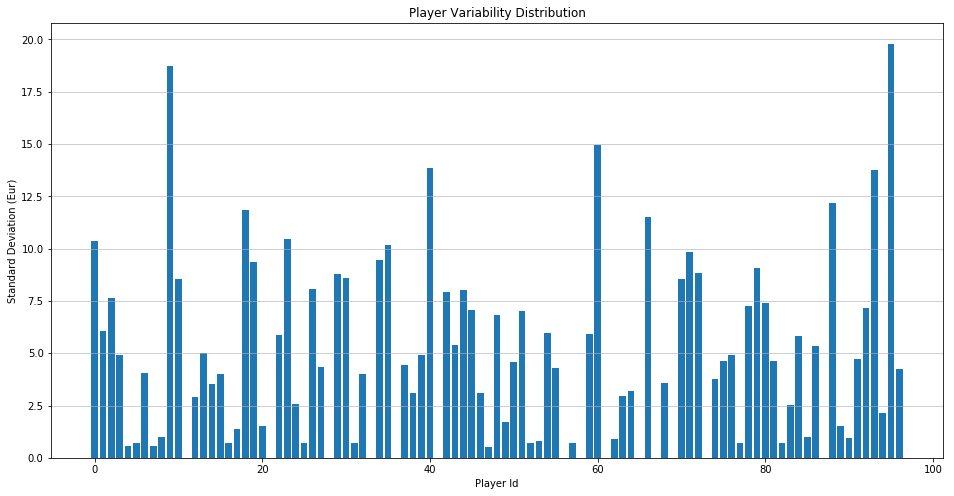

In [17]:
data = np.array(result_betting_variability) # numpy convert to string all values()
data = data.astype(int)

df = pd.DataFrame({'operator_id': data[:,0], 
                   'player_id': data[:,1],
                   'bettings': data[:,2]})

# calculate the standard deviation grouped by operator and player and replace NaN to zero
df = df.groupby(['operator_id', 'player_id']).std().fillna(0)
#print(df.groupby(['operator_id', 'player_id']).head())

# convert pandas dataframe to numpy vector
betting_variability_values = df.values.flatten()

# plot player variance
plt.figure(figsize=(16, 8))
plt.bar(np.arange(betting_variability_values.size), betting_variability_values)
plt.title('Player Variability Distribution')
plt.xlabel('Player Id')
plt.ylabel('Standard Deviation (Eur)')
plt.grid(axis='y', alpha=0.75)
plt.show()

## Betting Trajectory

Get raw Dataset for Betting Trajectory. The tendency to increse or decrease the amount of wagers money

In [18]:
cursor = cnx.cursor()

query = ("SELECT pl.operator_id, pl.player_id, bettings as total"
         " FROM gaming.player pl, gaming.account ac"
         " WHERE pl.operator_id = ac.operator_id"
         "   AND pl.player_id = ac.player_id"
         "   AND YEAR(pl.activation_date) = %s") %YEAR

cursor.execute(query)

# return a list of tuples
result_betting_trayectory = list(cursor.fetchall())

Plot betting trajectory distribution per player

/home/miguel/.local/lib/python3.5/site-packages/scipy/stats/_stats_mstats_common.py:116: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/home/miguel/.local/lib/python3.5/site-packages/scipy/stats/_stats_mstats_common.py:126: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/miguel/.local/lib/python3.5/site-packages/scipy/stats/_stats_mstats_common.py:128: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


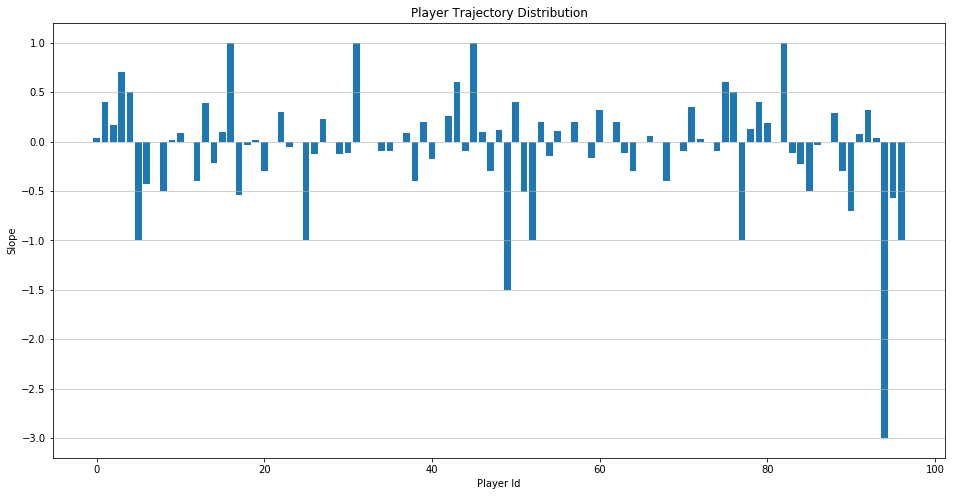

In [19]:
data = np.array(result_betting_trayectory) # numpy convert to string all values()
data = data.astype(int)

df = pd.DataFrame({'operator_id': data[:,0], 
                   'player_id': data[:,1],
                   'bettings': data[:,2]})

# get bettings grouped by operator and player
result = df.groupby(['operator_id', 'player_id'])['bettings'].apply(list)

# calculate the slope for each bettings collection group by operator and player
betting_trajectory_values = [linregress(np.arange(len(x)), x).slope for x in result] 

# replace NaN to zero
betting_trajectory_values = np.nan_to_num(betting_trajectory_values)

# plot player trayectory
plt.figure(figsize=(16, 8))
plt.bar(np.arange(0, len(betting_trajectory_values)), betting_trajectory_values)
plt.title('Player Trajectory Distribution')
plt.xlabel('Player Id')
plt.ylabel('Slope')
plt.grid(axis='y', alpha=0.75)
plt.show()

## Clustering Betting from predictors (independent characteristics)

Before clustering to assure comparatibility, we standardized all variables using z transformation

In [20]:
predictors = pd.DataFrame({'Frequency (days)': betting_frequency_values, 
                           'Intensity (bets)': betting_intensity_values,
                           'Variability (Euro)': betting_variability_values,
                           'Trajectory (Slope)': betting_trajectory_values})

X = stats.zscore(predictors)

# create k-means for the cluster
model = KMeans(n_clusters=4)
model.fit(X)

def ClusterIndicesNumpy(clustNum, labels_array):
    return np.where(labels_array == clustNum)[0]

labels = Counter(model.labels_)
centroids = model.cluster_centers_

columns = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4']
index =['Frequency(days)', 'Intensity(bets)', 'Variability (Eur)', 'Trajectory (Slope)', 'N']

centroides = centroids.T
centroides = np.vstack([centroides, [len(ClusterIndicesNumpy(0, model.labels_)),
                                     len(ClusterIndicesNumpy(1, model.labels_)),
                                     len(ClusterIndicesNumpy(2, model.labels_)),
                                     len(ClusterIndicesNumpy(3, model.labels_))]])

print(pd.DataFrame(centroides, index = index, columns = columns))


# recover all instances froma cluster label
#print(ClusterIndicesNumpy(3, model.labels_))

# to call the predict function with a single observation
#model.predict([ 5.1, 3.5, 1.4, 0.2 ])


                    Cluster 1  Cluster 2  Cluster 3  Cluster 4
Frequency(days)     -1.019761  -0.084759   0.896303  -0.333897
Intensity(bets)      0.929856  -0.564608  -0.140191  -0.332718
Variability (Eur)    0.190396   0.232764   0.284727  -1.888840
Trajectory (Slope)  -0.194329   1.204053  -0.531906  -0.711858
N                   25.000000  26.000000  35.000000  11.000000


Generate Predictors Correlative Scatter MAtrix

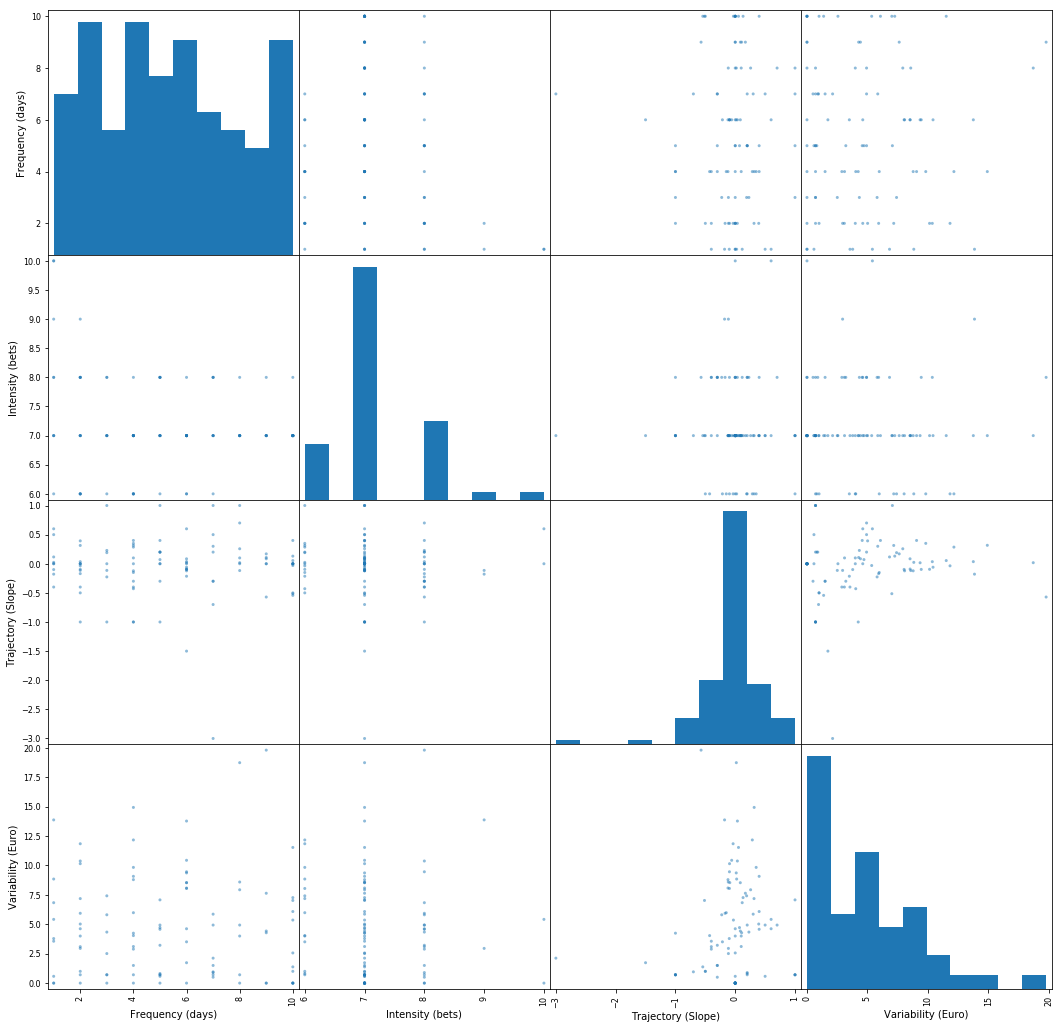

In [21]:
scatter_matrix(predictors, figsize=(18, 18))
plt.show()

 Generate Predictors Correlation Matrix Plot

                    Frequency (days)  Intensity (bets)  Trajectory (Slope)  \
Frequency (days)            1.000000         -0.145690           -0.000841   
Intensity (bets)           -0.145690          1.000000           -0.019672   
Trajectory (Slope)         -0.000841         -0.019672            1.000000   
Variability (Euro)         -0.023985         -0.053654            0.131563   

                    Variability (Euro)  
Frequency (days)             -0.023985  
Intensity (bets)             -0.053654  
Trajectory (Slope)            0.131563  
Variability (Euro)            1.000000  


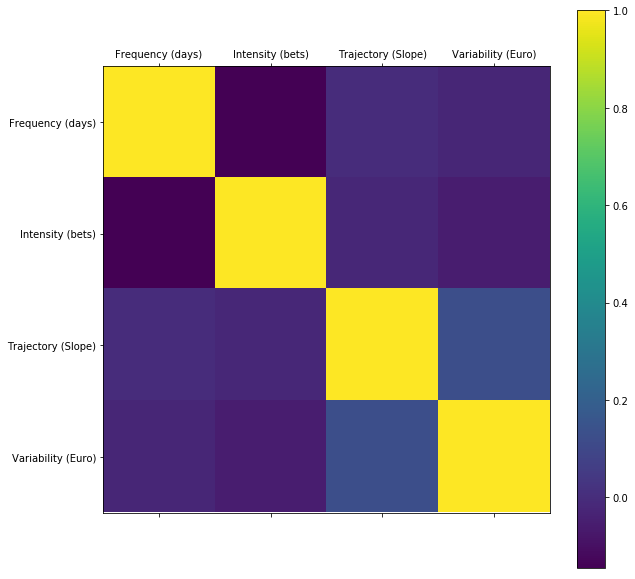

In [22]:
correlations = predictors.corr()
#display(Markdown('<font size="2">{}!</font>'.format(correlations)))
print(correlations)

plt.figure(figsize=(10, 10))
plt.matshow(correlations, fignum=1)
plt.xticks(range(len(predictors.columns)), predictors.columns)
plt.yticks(range(len(predictors.columns)), predictors.columns)
plt.colorbar()
plt.show()

Find optimal K cluster value from Elbow method

In [ ]:
# k means determine k
distortions = []
K = range(1,10)
for k in K:
    model = KMeans(n_clusters=k)
    model.fit(X)
    distortions.append(sum(np.min(cdist(X, model.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

Plot elbow method result

In [ ]:
# Plot the elbow
plt.figure(figsize=(16, 8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

## Clustering Age vs Profit

Study is exist any relation between the age and the profit in the period

In [25]:
# create dataset from database
cursor = cnx.cursor()

query = ("SELECT pl.birthdate, SUM(ac.profit) AS profit"
         " FROM gaming.player pl, gaming.account ac"
         " WHERE pl.operator_id = ac.operator_id"
         " AND pl.player_id = ac.player_id"
         " AND YEAR(pl.activation_date) = %s"
         " GROUP BY pl.birthdate, ac.operator_id, ac. player_id") %YEAR

cursor.execute(query)

# return a list of tuples
result_km_players = list(cursor.fetchall())

Transform date characteristics and create tuples

In [26]:
# separate tuples
dates, profits = zip(*result_km_players)

# convert string to date
#dates = [pd.to_datetime(d) for d in dates]

helper = np.vectorize(lambda x: datetime.combine(x, datetime.min.time()).timestamp())

X = []
for row in result_km_players:
    X.append([helper(row[0]), row[1]])

Plot Age vs Profit Scatter Plot

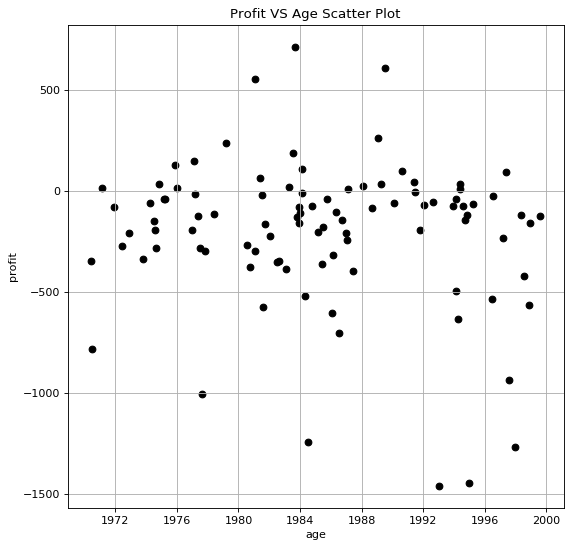

In [27]:
plt.figure(figsize=(8, 8), dpi=80)
plt.scatter(dates, profits, color='k')
plt.title("Profit VS Age Scatter Plot")
plt.xlabel("age")
plt.ylabel("profit")
plt.grid()
plt.show()

Design de k-means with 2 clusters model for dataset

In [28]:
model = KMeans(n_clusters=2).fit(X)

Print k-means centroides

In [29]:
centroides = []
for row in model.cluster_centers_:
    centroides.append((datetime.fromtimestamp(int(round(row[0]))), row[1]))

print(centroides)    

centroides_dates, centroides_profits = zip(*centroides)

[(datetime.datetime(1992, 8, 9, 11, 24, 33), -247.47727272727275), (datetime.datetime(1979, 5, 18, 0, 10, 11), -164.0188679245283)]


Plot the scatter plot and the centroides for tha dataset

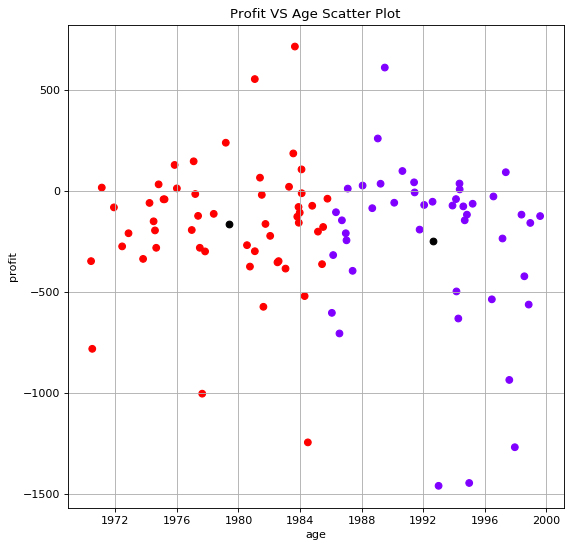

In [30]:
plt.figure(figsize=(8, 8), dpi=80)
plt.scatter(dates, profits, c=model.labels_, cmap='rainbow')
plt.scatter(centroides_dates ,centroides_profits, color='black')
plt.title("Profit VS Age Scatter Plot")
plt.xlabel("age")
plt.ylabel("profit")
plt.grid()
plt.show()